In [1]:
import matplotlib.pyplot as plt
img_path = '../resources/sand_480270.jpg'

In [2]:
from resize_package import generate_horizontal_filter, generate_vertical_filter

In [5]:
# Load in image
import numpy as np
from PIL import Image

def decompose_image(file_path):
    # Open the image file
    img = Image.open(file_path)
    
    # Convert the image to a NumPy array
    img_array = np.array(img)
    
    # Check if the image is RGB
    if len(img_array.shape) != 3 or img_array.shape[2] != 3:
        raise ValueError("The image must be in RGB format")
    
    # Decompose into R, G, B channels
    r_channel = img_array[:, :, 0]
    g_channel = img_array[:, :, 1]
    b_channel = img_array[:, :, 2]
    
    
    return r_channel, g_channel, b_channel

src_h, src_w = 270, 480
print(src_h,src_w)
dst_h, dst_w = 135,240 

270 480


In [19]:
def build_horizontal_matrix():
    h_pos, h_coeffs = generate_horizontal_filter(src_w, dst_w)
    # Create sparse matrix for horizontal scaling
    H = np.zeros((src_w, dst_w))
    filter_size = 4
    print(H.shape)
    # Fill in the matrix based on filter positions and coefficients
    for x in range(dst_w):
        src_pos = h_pos[x]
        for z in range(filter_size):  # Using filter size of 4
            if src_pos + z < src_w:
                H[src_pos + z, x] = h_coeffs[x * filter_size + z]# Normalize by FILTER_BITS 
    return H

In [20]:
def build_vertical_matrix():
    print(src_h, dst_h)
    v_pos, v_coeffs = generate_vertical_filter(src_h, dst_h)
    # Create sparse matrix for vertical scaling
    V = np.zeros((dst_h, src_h))
    filter_size = 4
    # Fill in the matrix based on filter positions and coefficients
    for y in range(dst_h):
        src_pos = v_pos[y]
        for z in range(filter_size):
            if src_pos + z < src_h:
                V[y, src_pos + z] = v_coeffs[y * filter_size + z]  # Normalize by FILTER_BITS
    return V

(480, 240)
270 135


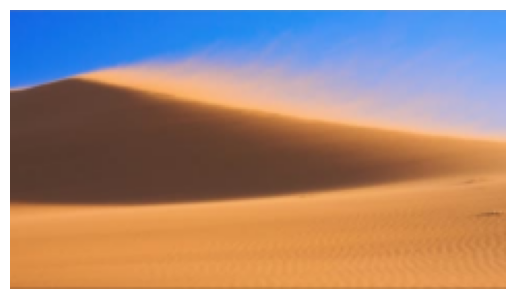

In [24]:
W = build_horizontal_matrix()
H = build_vertical_matrix()
r, g, b = decompose_image(img_path)
r = np.array(r)
r_resize = H @ r @ W
g = np.array(g)
g_resize = H @ g @ W
b = np.array(b)
b_resize = H @ b @ W
# Combine channels back into RGB image
resized_img = np.dstack((r_resize, g_resize, b_resize))/ (1<<28)
resized_img = np.clip(resized_img, 0, 255).astype(np.uint8)
# Set figure size to match image dimensions
plt.imshow(resized_img)
plt.axis('off')
plt.show()


### H @ R @ W where H and W can be precompute
### H size : (dst_h, src_h)
### W size : (src_w, dst_w)  
### Prove: (aH)@r@(Wb) =a@r_resize@b

In [26]:
# Public Setup for Freivald's mod 2^64 (not realy secure)
goldilocks_prime = 2**64 - 2**32 + 1
freivalds_randomness_left = np.random.randint(0, goldilocks_prime - 1, size=135, dtype=np.uint64)
freivalds_randomness_right = np.random.randint(0, goldilocks_prime - 1, size=240, dtype=np.uint64)
rLeftTB = (freivalds_randomness_left @ H) 
rRightTB = (W @ freivalds_randomness_right)
r_resize_2 = (H @ r) @ W

# # Verify
# assert(((rLeftTB @ r) @ rRightTB) == (freivalds_randomness_left @ r_blurred) @ freivalds_randomness_right)
print(((rLeftTB @ r) @ rRightTB))
print((freivalds_randomness_left @ r_resize_2) @ freivalds_randomness_right)

1.3107135001381173e+53
1.3107135001381171e+53


In [ ]:
# todo, write in succinct:
# todo, (1<<28)